# Simulated Trading and Financial Data in Python
### A workshop hosted by UNIT UQ, presented on 18/10/2022
#### Code written and presented by Joshua Aberdeen

## Overview
This workshop aims to educate attendees on methods for importing dense financial data into python, working with pandas dataframes objects once imported, and applications for this data included a trading simulator.

## DISCLAIMER

The code in this file runs fine at the time of this workshop, however some data is time-sensitive and may return errors at some time following this workshop.

This file and its associated presentation are for educational purposes only, and do not contain any financial advice. It is not the recommendation of the author of this file and its associated presentation that its contents be used for any purposes other than education. It is not the recommendation of the author to use the yfinance python package to inform any financial decisions. This file, its associated presentation and its author are not affiliated with the creators of the yfinance python package (can be found at github.com/ranaroussi/yfinance), Ran Aroussi, or Yahoo! Inc or Alphabet Inc. Any code from this file that is executed is done so at your own risk, the author of this file and UNIT UQ take no responsibility for these actions.

## Introduction
Large investing and trading firms keep rich stock exchange data at their analysts and traders fingertips. If youre just a Uni student wanting to test some trading strategies in your spare time, that kind of data is a little out of reach, making it harder to test any trading or pricing theories you may have. 

We're going to have a look at how you can automate getting rich, dense stock exchange data into python, and some things you can do with it once it's there, including building your own trading simulator.

## Getting Data into Python
There are a number of ways to get stock exchange data into python:

*   API's - An Application Programming Interface is a broad term for an interface between a program and a server or data source. For our purposes, an API provides a link from your code to some source of stock market data. API's (and the data they link to) are reliable, high-frequency and very rich, but often costly.
*   Downloading CSV's from yahoo finance and importing them into python manually - exceptionally slow and repetitive, but completely free and easy for most people to do.
*   Data Scraping - Many websites freely publish stock market data, data scraping is a way to request this data and download it directly into python automatically, in a format that python can easily work with. This takes a decent bit of coding knowledge (and time) to code up yourself.
*   yfinance package - yfinance is a python package that scrapes data from yahoo finance for you, and imports it as pandas dataframes.

### Some Notes on Data Scrapers
*   It is important when using data scrapers (including yfinance) to consider its legality. Data scraping is in many cases and many countries perfectly legal (it's how Google's search engine works). However you should make sure to follow the terms of service of the website which you scrape from, and avoid copyright infringement. As rules of thumb: don't collect personally identifiable information, don't publish any scraped data without checking terms of service, don't scrape data too many times per minute, you can be blocked if you're slowing their servers down, and use the data for educational or personal non-commercial research purposes only.
*   It is also important to note that free, scraped data is often viewed as not being as reliable or accurate as a premium paid service like some API's. This is partially why it is not reccomended to use this data for real trading.

In [ ]:
# NOTE you will need to pip or conda install these packages the first time you use them. This is how it looks for yfinance
import sys
!{sys.executable} -m pip install yfinance
# and repeat the pip install line for all packages you dont have

In [110]:
# Import the yfinance package, and other packages used in this code
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import pytz
import tzlocal
import math
from time import sleep

### Historical Price Data

We can use the yfinance package as below to get historical data from a stock's ticker:

In [ ]:
# Create yfinance ticker class for the ASX200
a200 = yf.Ticker("^AXJO")
# Download historical price data for ASX200 at 1 minute intervals
a200H = a200.history(start="2022-10-12", end="2022-10-19", interval="1h")
# Display the historical price data
display(a200H)

Note that we can specify data frequencies of 1m, 2m, 5m, 15m, 30m, 1h, 1d, 1wk, 1mo. However 1m data is only available for the past 7 days, and any data less than 1d is only available for the last 60 days. We can plot the closing price data if we want:

In [ ]:
# Plot the historical price data
a200H['Close'].plot(title="Share price of ASX200", ylabel = "Price ($)")

We can automate this process for any stock using a function, as follows:

In [68]:
# Function to dowload and plot historical price data for a stock
def graph(tick, start, end, interval):
  histData = yf.Ticker(tick).history(start=start, end=end, interval=interval)
  histData['Close'].plot(title="Price of "+tick, ylabel = "Price")

And to test our function works, here's another lovely picture:

In [ ]:
# Graph the downfall of bitcoin
graph("BTC-USD", "2021-11-01", "2022-10-17", "1d")

We can also get the prices for multiple tickers at once, including currency exchange data.

In [ ]:
# Get close price data for multiple tickers at once
yf.download(["AAPL", "^AXJO", "AUDUSD=X", "A2M.AX"], "2022-10-12", end="2022-10-19", interval="1h").Close

You could use such dense price data to attempt to find trends, estimate some form of predictive model (perhaps an ISLM style model if you've completed ECON3350), test trading strategies (as we will see soon) and any number of other applications.

### Financial Data (Proper Nerd Stats)

You may be thinking "Cool graphs buddy, but what else have you got?"

Well it's not just price data that's available in the yfinance package. Below is some of the other data we can get using yfinance. There's even more too, including split and dividend history, earnings, sustainability etc. Have a look on the yfinance github for the full list.

In [ ]:
# Get analyst recommendations
yf.Ticker("BHP").get_recommendations()

In [ ]:
# Get general info
yf.Ticker("AAPL").info

In [ ]:
# Get official financial data
yf.Ticker("AAPL").get_financials()

In [ ]:
# Get businesses cash flow
yf.Ticker("AAPL").cashflow

In [ ]:
# Get forecasts and predictions
yf.Ticker("AAPL").get_analysis()

In [ ]:
# Get business balance sheet
yf.Ticker("AAPL").balancesheet

Naturally with this amount of data there are more applications than I could begin to discuss; valuations etc. However I am not an analyst so I won't pretend that I know how to do that. Instead here is a simple example of computing the acid test ratio, that should give an indication of how you can work with these dataframes to do other calculations.

In [ ]:
# How to retreive a single cell of data
balSheet = yf.Ticker("AAPL").balancesheet
# Retrieve via index numbers
display(balSheet.iloc[0,1])
# Retreive via index names
display(balSheet.loc["Total Liab", "2020-09-26"])

In [113]:
# Function to get the acid test for a stock for a year (default is most recent year)
def getRatiod(ticker, yearIndex=0):
    # Get balance sheet data
    balSheet = yf.Ticker(ticker).balancesheet
    # Calculate acid test ratio
    ratio = (balSheet.loc["Cash"][yearIndex] + balSheet.loc["Net Receivables"][yearIndex]
             + balSheet.loc["Short Term Investments"][yearIndex]) / balSheet.loc["Total Current Liabilities"][yearIndex]
    # Print the Ratio with a statement
    print("The Acid Test Ratio for "+ticker+" as of "+str(balSheet.columns[yearIndex])+" is "+str(ratio))

Let's test this function:

In [114]:
# Get acid test ratio for apple for the most recent year
getRatiod("AAPL")

The Acid Test Ratio for AAPL as of 2021-09-25 00:00:00 is 0.9096596297447422


In [115]:
# Get acid test ratio for apple for the third most recent year
getRatiod("MSFT", 2)

The Acid Test Ratio for MSFT as of 2020-06-30 00:00:00 is 2.3302862674595493


## Application - Portfolio Simulator
We can make some functions to automatically simulate a stock portfolio (or as many portfolios as you'd like) using pandas dataframes.

The first step is to set up a pandas dataframe to keep track of all of our assets.
We'll start off by giving ourselves some theoretical cash to splash:

In [116]:
# Create a dataframe to keep track of portfolio holdings
pf = pd.DataFrame({"Qty": [50000]}, index = ['$$$$'])
print(pf)

        Qty
$$$$  50000


Let's say we want to give ourselves 5 apple shares as well to start with, we could represent this as follows:

In [117]:
# Add a new row to the dataframe with apple share holdings
pf.loc["AAPL"] = [5]
print(pf)

        Qty
$$$$  50000
AAPL      5


Now we want to make a function get the value of our portfolio. Of course we could just look up the current value of apple stock and do some simple maths, but instead we will make a function that will work for all shares we might have.

In [118]:
# Function to compute the value of the portfolio from dataframe
def pfValue(pf):
    value = 0
    # Loop through all shares
    for tick in pf.index.values:
        tickQty = pf.loc[tick, "Qty"]
        if tick == "$$$$":
            # The value of each unit of cash is 1
            tickVal = 1.0
        else:
            # Download stock price
            tickVal = yf.Ticker(tick).info["previousClose"]
        # Add the total value of the stocks
        value += tickVal*tickQty
        # Stop program making too frequent calls
        sleep(5)
    return value

Let's test it:

In [119]:
# Get value of portfolio
pfValue(pf)

50691.9

We want to automate buying/selling shares and the effects it will have on the portfolio, so we'll do this using basic preliminary functions too:

In [120]:
# Function to buy a stock
def buy(pf, ticker, qty):
    # Get value of stock
    tickVal = yf.Ticker(ticker).info["previousClose"]
    # Check we have enough cash to buy the shares
    if pf.at["$$$$", "Qty"] >= qty*tickVal:
        # Add share to portfolio if not already there
        if ticker not in pf.index.values:
            pf.loc[ticker] = [0]
        # Subtract cost of shares
        pf.loc["$$$$", "Qty"] -= qty*tickVal
        # Add purhcased shares
        pf.loc[ticker, "Qty"] += qty
    else:
        # If theres not enough cash to buy
        print("You don't have enough cash for that big spender")

def sell(pf, ticker, qty):
    # Get value of stock
    tickVal = yf.Ticker(ticker).info["previousClose"]
    # Check we own the shares to sell
    if ticker in pf.index.values and pf.at[ticker, "Qty"] >= qty:
            # Add price of shares to cash
            pf.loc["$$$$", "Qty"] += qty*tickVal
            # Subtract shares
            pf.loc[ticker, "Qty"] -= qty
    else:
        # If we don't own the shares to sell
        print("Sorry, no naked selling")

Lets test these functions:

In [121]:
# Buy a share of tesla stock
buy(pf, "TSLA", 2)
# Sell two shares of apple stock
sell(pf, "AAPL", 2)
# Sell six shares of apple stock
sell(pf, "AAPL", 6)
# Check functions worked
print(pf)

Sorry, no naked selling
           Qty
$$$$  49866.78
AAPL      3.00
TSLA      2.00


Well now that we have these functions, we can link them into any algorithm we make. Let's test this below on a naive but simple example algorithm: one that buys any share that has a return on equity > 0.5. This should provide an example of how you could test your own algorithm, just by replacing the "if" condition with something else.

In [122]:
# Tickers to watch
watchers = ["AAPL", "TSLA", "MSFT"]
for ticker in watchers:
    retOnEquit = yf.Ticker(ticker).info["returnOnEquity"]
    # Check if ticker beats return on equity threshold
    if retOnEquit > 0.5:
        # Buy one of the stock
        buy(pf, ticker, 1)
    # Wait 3 seconds
    sleep(3)
# Show portfolio
print(pf)

          Qty
$$$$  49728.4
AAPL      4.0
TSLA      2.0


We of course want to be able to save this portfolio to track how it does over time, so we will save it to a .csv file, which we can import back in as a dataframe any time in the future, check how its value has changed, do some more buying or selling etc.

In [ ]:
# How to export our portfolio dataframe
pf.to_csv("firstPortfolio.csv")

In [ ]:
# How to import our portfolio dataframe back in
pfImported = pd.read_csv("firstPortfolio.csv")

Well that's a nice little concept demonstration, but there are some serious limitations to be fixed.

*   We only have a record of which shares we have at the present, we want to know our portfolio's history too
*   Our current price for buying or selling is the last closing price, when in reality it would be the next future price (if we are doing a no limits order). We also have no way to process limit orders.
*   No ability to account for differences in currency, limiting you to trading only in one currency

## Improved Portfolio Simulator

We'll extend our functions to fix this, using a class to neatly contain all of our extended functions and data for our simulated portfolio. To help those who aren't familiar with classes, I'll give an example of a class below.


In [123]:
# Example of a class
class dog:
    # Method to initialise class
    def __init__(self, myBreed):
        # Add breed property to class
        self.breed = myBreed
    # Method to print the breed
    def speak(self):
        print("Hello, I am a " + self.breed)

Let's test this:

In [124]:
# Create instance of dog class
rufus = dog("German Shepherd")
# Call speak method
rufus.speak()
# Call breed property
rufus.breed

Hello, I am a German Shepherd


'German Shepherd'

Now we move onto the portfolio class, fixing the problems listed above. There's a lot here, so read the comments in the code if you want to follow every step, but here is an overview:
* We simulate buying in real time by recording an order in a dataframe. Then once price data has been released following when we placed the order we will execute that order (if the limits are met)
* We keep track of all our holdings and pending orders in dataframes. These dataframes can be saved locally in a process called pickling when we want to close python. We also record our holdings any time they change, to keep a historical record.
* We have a reserves cash account, allowing us to transfer more money to the balance to be used, while keeping track of where this money came from.
* We convert all prices to USD by downloading the relevant exchange rates, and we make all time objects timezone aware to be able to compare "absolute time" between time zones.

A mockup of the dataframe we will use to keep track of securities holdings:
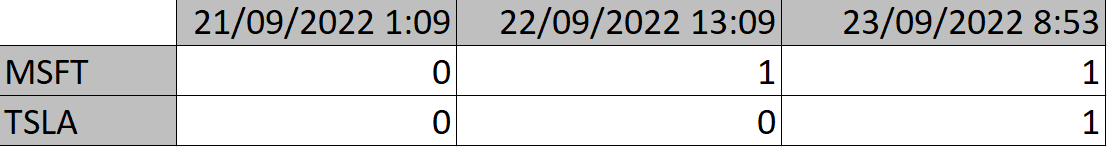

A mockup of the dataframe we will use to keep track of cash holdings:
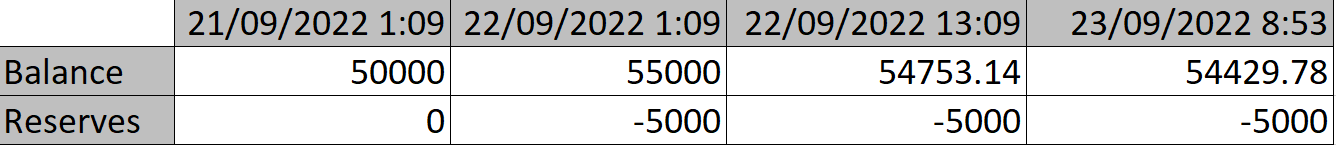

A mockup of the dataframe we will use to keep track of orders:
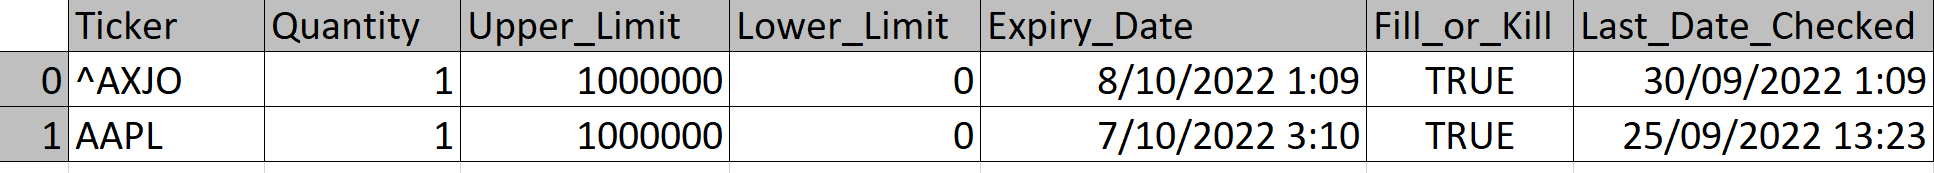

In [171]:
class portfolio:
    # Method to initialise portfolio class
    def __init__(self, nameOrNew="new", balance=50000):
        # Get your current timezone, could alternatively use any timezone you want
        self.timeZone = tzlocal.get_localzone_name()
        # If making a portfolio from scratch
        if nameOrNew == "new":
            # Take current time
            now = dt.datetime.now(pytz.timezone(self.timeZone))
            # Set empty dataframes as security holdings, cash holdings and orders properties
            self.secHoldings = pd.DataFrame(columns=[now])
            self.cashHoldings = pd.DataFrame([[balance], [0]], ['Balance', 'Reserves'], [now])
            self.orders = pd.DataFrame(columns=['Ticker', 'Quantity', "Upper_Limit", "Lower_Limit", "Expiry_Date", "Fill_or_Kill", "Last_Date_Checked"])
            # Set name property to 0, since it's a new portfolio and doesnt have a name yet
            self.name = 0
        # If importing a porfolio from pickle files
        else:
            # Read in dataframes from pickle files as security holdings, cash holdings and orders properties
            self.secHoldings = pd.read_pickle(nameOrNew + "SecHoldings.pickle")
            self.cashHoldings = pd.read_pickle(nameOrNew + "CashHoldings.pickle")
            self.orders = pd.read_pickle(nameOrNew + "Orders.pickle")
            # Set name property from imported files
            self.name = nameOrNew
            
    # Method to export dataframes to files with custom name, using pickling
    def export(self, name=0):
        if name == 0 and self.name == 0:
            # If this portfolio is new (wasn't imported) and hasnt been named
            raise Exception("You haven't set a name for this new portfolio. Please include your new name as an argument")
        elif name ==0:
            # If the portfolio was imported and no other name specified, use the imported name
            name = self.name
        self.secHoldings.to_pickle(name + "SecHoldings.pickle")
        self.cashHoldings.to_pickle(name + "cashHoldings.pickle")
        self.orders.to_pickle(name + "Orders.pickle")
    
    #===========================================================================
    # Cash-specific Private Methods
    
    # Changes the cash holdings by any specified amount for any time
    def __cashChange(self, amount, time):
        # Copy most recent cash holdings
        latestData = self.cashHoldings.iloc[:,-1].copy()
        # Add amount to balance
        latestData["Balance"] += amount
        # Append updated holdings to dataframe
        self.cashHoldings[time]= latestData
    #==========================================================================
    # Cash-specific Methods
    
    # Takes cash from reserves and moves it to balance. Simulates giving 
    # yourself more money to trade with but keeps track of how much you've spent
    def deposit(self, amount):
        # Get current time
        now = dt.datetime.now(pytz.timezone(self.timeZone))
        # Copy most recent cash holdings
        latestData = self.cashHoldings.iloc[:,-1].copy()
        # Add amount to balance and subtract from reserves
        latestData["Balance"] += amount
        latestData["Reserves"] -= amount
        # Append updated holdings to dataframe
        self.cashHoldings[now]= latestData
    
    # Opposite of deposit    
    def withdraw(self, amount):
        self.deposit(-amount)

    #==========================================================================
    # Order-specific Private Methods
    
    # Changes the securities holdings by any specified amount for any stock at a given time
    def __secChange(self, ticker, qtyDiff, time):
        if ticker not in self.secHoldings.index.values:
            # Add stock to holdings if not owned before
            self.secHoldings.loc[ticker] = 0
        # Copy most recent securities holdings
        latestData = self.secHoldings.iloc[:,-1].copy()
        # Change quantity of given stock
        latestData[ticker] += qtyDiff
        # Append updated holdings to dataframe
        self.secHoldings[time]= latestData
    
    # Deletes any order from orders dataframe by row index i
    def __delOrder(self, i):
        self.orders = self.orders.drop(i)
    
    # Returns close price data for a list of tickers converted to USD using live exchange rate
    def __getUSDPrices(self, tickers, startTime, endTime, intervals):
        # Get closing price data for tickers in local currency
        allPriceData = yf.download(tickers, start=startTime, end=endTime, interval=intervals).Close
        # Stop the program early if theres no price data to prevent errors
        if allPriceData.index.empty:
            return 0
        # If theres only one ticker it will return a pandas series object, convert this to a dataframe
        if not isinstance(allPriceData, pd.DataFrame):
            allPriceData = allPriceData.to_frame(name = tickers[0])
        # Empty lists to store data
        tickCurrency = {}
        convTickers = []
        for ticker in allPriceData.columns:
            # Currency of ticker data
            tickCurrency[ticker] = yf.Ticker(ticker).info["currency"]
            if not tickCurrency[ticker] == "USD" and not tickCurrency[ticker] in convTickers:
                    # Add to list of all currencies whose data to download
                    convTickers.append(tickCurrency[ticker]+"USD=X")
        if not len(convTickers) == 0:
            # Download conversion rate data
            allConvData = yf.download(convTickers, start=startTime, end=endTime, interval=intervals).Close
            # If theres only one ticker it will return a pandas series object, convert this to a dataframe
            if not isinstance(allConvData, pd.DataFrame):
                allConvData = allConvData.to_frame(name = convTickers[0])
            for ticker in tickCurrency.keys():
                if not tickCurrency[ticker] == "USD":
                    # Make note of the ticker for conversion rate
                    convTicker = tickCurrency[ticker]+"USD=X"
                    convInd = 0
                    for time in allPriceData.index:
                        if not math.isnan(allPriceData.loc[time, ticker]):
                            # Get first conversion rate after the current time
                            while allConvData.index[convInd] < time and convInd < len(allConvData.index):
                                convInd += 1
                            convRate = allConvData.loc[allConvData.index[convInd], convTicker]
                            # Convert price to USD
                            allPriceData.loc[time, ticker] *= convRate
        return allPriceData
        
    #==========================================================================
    # Order-specific Methods

    # Add an order with options to specify price limits, expiration data, fill or kill, (deletes order
    # if not immediately filled), and the option to delete other orders on the same stock
    def addOrder(self, ticker, qty=1, upLim=float('inf'), lowLim=-float('inf'), expDate = "week", FoK = True, delOthers = True):
        # Get current time
        now = dt.datetime.now(pytz.timezone(self.timeZone))
        # Default expiry date is one week, need to convert this to a date a week from now
        if expDate == "week":
            expDate = now + dt.timedelta(days=7)
        # Delete other orders on same stock
        if delOthers:
            ordersToDel = []
            for order in range(len(self.orders.index)):
                if self.orders.Ticker[order] == ticker:
                    ordersToDel.append(order)
            self.__delOrder(ordersToDel)
        # Add order to orders dataframe
        newEntry = pd.Series(data={"Ticker":ticker, 'Quantity':qty, "Upper_Limit":upLim, "Lower_Limit":lowLim, "Expiry_Date":expDate, "Fill_or_Kill":FoK, "Last_Date_Checked":now})
        self.orders = self.orders.append(newEntry, ignore_index=True)

    # Deletes every order in order book
    def delAllOrders(self):
        self.orders = self.orders.iloc[:0,:].copy()
    
    # Executes orders, (checks to see which orders can be filled, and deletes any expired or FoK orders)
    def exeOrders(self):
        # Stop now if there are no orders to complete
        if self.orders.Ticker.empty:
            return
        # Fill list of tickers to download data for
        orderTickers = []
        for ticker in self.orders.Ticker.unique():
            orderTickers.append(ticker)
        # Get current time
        now = dt.datetime.now(pytz.timezone(self.timeZone))
        # Get the earliest date since one of the orders has been checked if it can be executed
        lastDateChecked = min(self.orders.Last_Date_Checked).astimezone(pytz.timezone(self.timeZone))
        # Get price data from last date checked to now
        allPriceData = self.__getUSDPrices(orderTickers, lastDateChecked, now, "1m")
        # Stop now if there is no price data
        if not isinstance(allPriceData, pd.DataFrame):
            return 0
        # Chronologically check which orders can be filled or deleted at every time in data
        for time in allPriceData.index:
            # Keep track of orders that should be deleted
            ordersToDel = []
            for order in self.orders.index:
                # Delete order if expired
                if time >= self.orders.Expiry_Date[order]:
                    ordersToDel.append(int(order))
                # Otherwise if the time is after the last date checked
                elif self.orders.Last_Date_Checked[order] <= time:
                    # Get the price of the stock at the time being checked
                    ticker = self.orders.Ticker[order]
                    marketPrice = allPriceData.loc[time, ticker]
                    # If the market is open at that time
                    if not math.isnan(marketPrice):
                        # Delete any fill or kill orders
                        if self.orders.Fill_or_Kill[order]:
                            ordersToDel.append(int(order))
                        # Check the price limits hold
                        if self.orders.Lower_Limit[order] < marketPrice < self.orders.Upper_Limit[order]:
                            orderQuantity = self.orders.Quantity[order]
                            # If we are selling, sell the minimum of ordered quantity and currently held shares,
                            # stops "naked" selling
                            if orderQuantity < 0:
                                currentHoldings = self.secHoldings.loc[:,ticker].iloc[-1]
                                possOrderQuantity = max(orderQuantity, -1*currentHoldings)
                            # If we are buying, buy the minimum of ordered quantity and what we can buy with cash holdings
                            else:
                                currentCash = self.cashHoldings.loc["Balance", :].iloc[-1]
                                possOrderQuantity = min(orderQuantity, int(currentCash/marketPrice))
                            # Change security holdings by quantity bought or sold
                            self.__secChange(ticker, possOrderQuantity, time)
                            # Change cash holdings by amount spent or earned
                            self.__cashChange(-possOrderQuantity*marketPrice, time)
                            # Subtract fullfilled shares from order, leave the rest standing
                            self.orders.loc[order, "Quantity"] -= possOrderQuantity 
                # Delete orders that have been filled entirely
                if self.orders.Quantity[order]==0:
                    ordersToDel.append(int(order))
            # Delete all orders that have been queued to delete
            self.__delOrder(ordersToDel)
        # Update last date checked to the most recent data available for all remaining orders
        newLDC = allPriceData.index[-1]
        self.orders.assign(Last_Date_Checked = newLDC)
    
    #==========================================================================
    # Performance-specific Methods   

    def fullHistory(self):
        # Stop now if we havent purchased anything yet
        if self.secHoldings.index.empty:
            return
        # Collect list of tickers we have owned at some point
        histTickers = []
        for ticker in self.secHoldings.index:
            histTickers.append(ticker)
        # Get current time
        now = dt.datetime.now(pytz.timezone(self.timeZone))
        # Get time when portfolio was first made
        pfStart = self.secHoldings.columns[0].astimezone(pytz.timezone(self.timeZone))
        # Request price data for all tickers owned from the start of the portfolio to now
        allPriceData = self.__getUSDPrices(histTickers, pfStart, now, "1m")
        # Indices to keep track of most recent holdings dates
        lastSecInd = 0
        lastCashInd = 0
        # List to track portfolio value over time 
        histVal = []
        # List to track last available holdings value for each ticker (to consider when shares trade at different times)
        lastTickVals = self.secHoldings.iloc[:,0].copy()
        # Chronologically stepping through data over time
        for time in allPriceData.index:
            if time.tzinfo == None:
                time = time.tz_localize("UTC")
            # Get most recent security and cash holding prior to time considered
            while lastSecInd < len(self.secHoldings.columns)-1:
                if self.secHoldings.columns[lastSecInd+1] > time:
                    break
                lastSecInd += 1
            while lastCashInd < len(self.cashHoldings.columns)-1:
                if self.cashHoldings.columns[lastCashInd+1] > time:
                    break
                lastCashInd += 1
            for ticker in self.secHoldings.index:
                # Get price in USD
                marketPrice = allPriceData.loc[time, ticker]
                # If market is open check for any changes in holdings or price
                if not math.isnan(marketPrice):
                    lastSecDate = self.secHoldings.columns[lastSecInd]
                    lastCashDate = self.cashHoldings.columns[lastCashInd]
                    # Save updated last value for the ticker
                    lastTickVals.loc[ticker] = marketPrice * self.secHoldings.loc[ticker, lastSecDate]   
            # Get total value of all security holdings
            value = lastTickVals.iloc[:].sum()
            # Add cash holdings value
            value += self.cashHoldings.loc["Balance", lastCashDate] + self.cashHoldings.loc["Reserves", lastCashDate]
            # Append total value at time considered to list
            histVal.append(value)
        # Create dataframe with times for each value
        valuesDf = pd.DataFrame({'Value':histVal}).set_index(allPriceData.index)
        # Plot the value over time
        valuesDf.Value.plot(title="Value of Portfolio", ylabel = "Price")
        display(valuesDf)

Let's test some of these methods on a new portfolio we'll create:

In [172]:
# Create new portfolio
testPf = portfolio(balance = 100000)

In [173]:
# Test deposit method
testPf.deposit(5000)

In [174]:
# Check deposit method worked
testPf.cashHoldings

,2022-10-18 21:33:25.141595+10:00,2022-10-18 21:33:25.785721+10:00
Balance,100000,105000
Reserves,0,-5000


In [175]:
# Test some orders
testPf.addOrder(ticker="AAPL")
testPf.addOrder(ticker="MC.PA", upLim=2000, lowLim=1500, FoK=False)

In [176]:
# Check orders worked
testPf.orders

,Ticker,Quantity,Upper_Limit,Lower_Limit,Expiry_Date,Fill_or_Kill,Last_Date_Checked
0,AAPL,1,inf,-inf,2022-10-25 21:33:27.364697+10:00,True,2022-10-18 21:33:27.364697+10:00
1,MC.PA,1,2000.0,1500.0,2022-10-25 21:33:27.368697+10:00,False,2022-10-18 21:33:27.368697+10:00


In [177]:
# Attempt to execute orders
testPf.exeOrders()

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
- AAPL: No data found for this date range, symbol may be delisted
- MC.PA: No data found for this date range, symbol may be delisted


0

This shows one limitation of using the yfinance package; that prices are not available until 20 minutes later. So we cant execute orders until at least 20 minutes after we place them. Instead of waiting, let's export this portfolio, and import a portfolio I prepared earlier:

In [178]:
# Export portfolio
testPf.export(name = "testPf")

In [179]:
# Import pre-prepared example portfolio
samplePf = portfolio(nameOrNew = "samplePf")

In [180]:
# Show holdings
samplePf.secHoldings

,2022-10-14 01:10:30.449782+10:00,2022-10-13 11:11:00-04:00
MC.PA,0,1
AAPL,0,1


In [181]:
# Show orders
display(samplePf.orders)

,Ticker,Quantity,Upper_Limit,Lower_Limit,Expiry_Date,Fill_or_Kill,Last_Date_Checked
0,MC.PA,1,inf,-inf,2022-10-21 01:46:15.265927+10:00,True,2022-10-14 01:46:15.265927+10:00
1,^AXJO,1,2.0,1.0,2022-10-21 01:46:15.308838+10:00,False,2022-10-14 01:46:15.308838+10:00
2,AAPL,1,inf,-inf,2022-10-21 01:46:15.346344+10:00,True,2022-10-14 01:46:15.346344+10:00
3,A2M.AX,1,inf,-inf,2022-10-21 01:46:15.375360+10:00,True,2022-10-14 01:46:15.375360+10:00


In [182]:
# Execute pre-prepared orders
samplePf.exeOrders()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


In [183]:
# Show orders
display(samplePf.orders)

,Ticker,Quantity,Upper_Limit,Lower_Limit,Expiry_Date,Fill_or_Kill,Last_Date_Checked
1,^AXJO,1,2.0,1.0,2022-10-21 01:46:15.308838+10:00,False,2022-10-14 01:46:15.308838+10:00


In [184]:
# Show holdings
samplePf.secHoldings

,2022-10-14 01:10:30.449782+10:00,2022-10-13 11:11:00-04:00,2022-10-13 15:47:00+00:00,2022-10-13 23:00:00+00:00,2022-10-14 07:00:00+00:00
MC.PA,0,1,1,1,2
AAPL,0,1,2,2,2
A2M.AX,0,0,0,1,1


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed


,Value
Datetime,
2022-10-13 15:11:00+00:00,99998.808150
2022-10-13 15:12:00+00:00,99998.815970
2022-10-13 15:13:00+00:00,100000.043311
2022-10-13 15:14:00+00:00,100000.812282
2022-10-13 15:15:00+00:00,99999.841263
...,...
2022-10-18 11:15:00+00:00,100043.988327
2022-10-18 11:16:00+00:00,100043.791893
2022-10-18 11:17:00+00:00,100044.553897


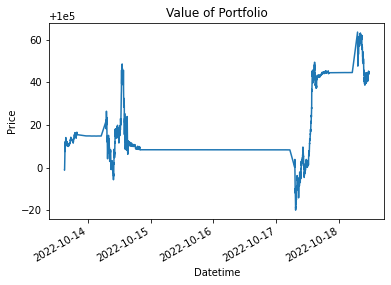

In [185]:
samplePf.fullHistory()

Now we would re-export this portfolio, and if we want to make any orders in the future or just check its performance we can import it back into any python file that has the porfolio class in it using the same method as above.

## Algorithmic Simulated Trading Example

Now that we have built the simulator, here is an example of how it could be used to test a strategy. This strategy is to use a time weighted average of analyst reccomendations (as imported using yfinance) to decide whether to buy, sell or hold a stock.

In [186]:
# Make a new portfolio
followHerd = portfolio(balance = 50000)
# Tickers to watch
watchers = ["AAPL", "TSLA", "MSFT", "NVDA", "BHP"]
# Empty list to track metric of analyst opinion
watchersMetr = []
for ticker in watchers:
    # Get current time
    now = dt.datetime.now()
    # Get analyst recommendations for ticker for last 90 days
    data = yf.Ticker(ticker).get_recommendations()
    start = now + dt.timedelta(days=-90)
    data = data.loc[start:now]
    # Empty list to track weight of each reccomendation
    weight = []
    # Empty list to track value of each reccomendation
    score = []
    for time in data.index:
        # Calculate how many days ago the recomendation was made
        timeDiff = now-time
        timeDiff = timeDiff.days
        # Get recommendation
        rating = data.loc[time, "To Grade"]
        # If recommendation is positive, assign value 1
        if rating in ["Outperform", "Overweight", "Buy", "Strong Buy", "Positive"]:
            score.append(1)
            # Also calculate time-discounted weight of recommendation
            weight.append(0.95**timeDiff)
        # If recommendation is negative, assign value -1
        elif rating in ["Underperform", "Underweight", "Strong Sell", "Sell", "Negative"]:
            weight.append(0.95**timeDiff)
            score.append(-1)
    # Normalise weights to sum to 1
    weights = [float(i)/sum(weight) for i in weight]
    # Calculate and save weighted average metric
    watchersMetr.append(sum(np.array(weights)*np.array(score)))
    # Sell if weighted average metric is less than -0.2
    if watchersMetr[-1] <= -0.2:
        followHerd.addOrder(ticker, qty=-1)
    # Sleep for 3 seconds
    sleep(3)
for i in range(len(watchers)):
    # Buy if weighted average metric is less than -0.2
    if watchersMetr[i] >= 0.5:
        ticker = watchers[i]
        followHerd.addOrder(ticker, qty=1)

In [187]:
# See what orders we would get if we used this strategy
followHerd.orders

,Ticker,Quantity,Upper_Limit,Lower_Limit,Expiry_Date,Fill_or_Kill,Last_Date_Checked
0,AAPL,1,inf,-inf,2022-10-25 21:36:36.413395+10:00,True,2022-10-18 21:36:36.413395+10:00
1,TSLA,1,inf,-inf,2022-10-25 21:36:36.413395+10:00,True,2022-10-18 21:36:36.413395+10:00
2,MSFT,1,inf,-inf,2022-10-25 21:36:36.413395+10:00,True,2022-10-18 21:36:36.413395+10:00
3,NVDA,1,inf,-inf,2022-10-25 21:36:36.413395+10:00,True,2022-10-18 21:36:36.413395+10:00


To see how well this strategy performs in the long term, you would execute these orders (possibly run the algo a few more times until you spend most of your balance), then save the portfolio, and revisit it when you want to see how the strategy has performed in the long term, or run the algo again to see if it decides to sell or buy more etc.

## Possible further improvements
* You could easily adapt this code to be used for backtesting, by substituting the "now" variable in the porfolio class methods with an argument to the method of some user specified time, then run your trading strategy passing past time values to this argument.
* You could add a transaction cost for each order.
* You could use a more sophisticated combination of high and low prices instead of the close if you think it could be more realistic.
* Track the profits from individual shares rather than just the portfolio as a whole
* You could create some form of GUI instead of entering via command line
* Fix any holes or edge cases I haven't considered (I'm only human sorry)
* And just about any other improvement you can possibly think of, such is the nature of high-level coding.